### Отчетное задание по предмету "Гибкие методологии управления"
__МИВТ-23-9, МИСИС__

__Выполнил: Вершинин Сергей__ 


#### Задание 1
- построить регрессионную модель и определить вероятность страхового случая для 40-летнего мужчины, не имеющего детей, на машине типа SUV;
- убедиться, что наиболее весомым фактором является количество детей.

##### Решение
Загрузим данные из файла в pandas DataFrame и посмотрим на них

In [1]:
import pandas as pd
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt 
warnings.filterwarnings('ignore')

In [148]:
df = pd.read_csv('AutoInsuranceRisk.csv', sep=';', index_col='ContractId')
df

,Age,Gender,Children,Profession,Customer Type,Multiple cars,Driving Licence Years,Car category,Annual Kilometers,Gearbox,Fuel,Claim
ContractId,,,,,,,,,,,,
1211,44,Woman,equalormorethan4,Unemployed,Agency,Yes,19,Sedan,36087,Automatic,Diesel,No
1212,21,Woman,0,Private Sector - Director,On-line,No,3,SUV,30367,Manual,Diesel,No
1213,76,Woman,1,Private Sector - Employee,Agency,No,19,SUV,27640,Automatic,Diesel,No
1214,29,Woman,equalormorethan4,Private Sector - Employee,On-line,No,11,Sedan,22780,Automatic,Diesel,No
1215,44,Man,0,Private Sector - Director,Agency,No,11,SUV,36477,Automatic,Diesel,No
...,...,...,...,...,...,...,...,...,...,...,...,...
6075,72,Woman,2,Independant,Agency,No,17,Sedan,50129,Manual,Diesel,No
6077,59,Woman,3,Public Sector - Manager,Agency,No,7,Sedan,19732,Automatic,Petrol,No
6078,52,Woman,equalormorethan4,Public Sector - Manager,Agency,No,5,SUV,20185,Manual,Diesel,No


Видим, что в наборе есть целевая (зависимая) переменная Claim. Также видим, что в наборе данных есть категориальные признаки, которые нужно закодировать для построения линейной модели логистической регрессии.

Дополнительно проверим данные на наличие пропусков.

In [114]:
df.isna().sum()

Age                      0
Gender                   0
Children                 0
Profession               0
Customer Type            0
Multiple cars            0
Driving Licence Years    0
Car category             0
Annual Kilometers        0
Gearbox                  0
Fuel                     0
Claim                    0
dtype: int64

Пропусков в данных нет. Теперь разделим набор на матрицу объект-признак X и вектор целевой переменной y. В векторе y сразу заменим значения 'Yes' на 1, а 'No' на 0. 

In [115]:
y = df['Claim'].replace({'Yes': '1', 'No': '0'}).astype('int64')
X = df.drop('Claim', axis=1)

Как говорилось выше, для построения линейной модели логистической регрессии нужно закодировать категориальные признаки, превратив их в числовые значения. Для этого воспользуемся методом OneHotEncoding.

In [129]:
cat_columns = X.select_dtypes(include=['object']).columns

one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output = False)
one_hot_encoder = one_hot_encoder.fit(X[cat_columns])
encoded_cat_columns = one_hot_encoder.get_feature_names_out(cat_columns)

X_ohe = pd.concat(
    [
        X.drop(cat_columns, axis=1).reset_index(drop=True),
        pd.DataFrame(one_hot_encoder.transform(X[cat_columns]), columns = encoded_cat_columns).reset_index(drop=True)
    ],
    axis=1
)

Посмотрим на получившийся после OneHot-кодирования набор признаков

In [130]:
cols = X_ohe.columns
cols

Index(['Age', 'Driving Licence Years', 'Annual Kilometers', 'Gender_Woman',
       'Children_1', 'Children_2', 'Children_3', 'Children_equalormorethan4',
       'Profession_Independant', 'Profession_Private Sector - Director',
       'Profession_Private Sector - Employee',
       'Profession_Private Sector - Manager',
       'Profession_Public Sector - Director',
       'Profession_Public Sector - Employee',
       'Profession_Public Sector - Manager', 'Profession_Retired',
       'Profession_Student', 'Profession_Unemployed', 'Customer Type_On-line',
       'Multiple cars_Yes', 'Car category_Sedan', 'Car category_Sport',
       'Gearbox_Manual', 'Fuel_Petrol'],
      dtype='object')

Видим, что в результате кодирования каждый категориальный признак был заменен на n-1 числовых признаков со значениями 0 и 1, где n-количество значений признака. 

Теперь нормализуем данные, чтобы они имели среднее значение 0 и стандартное отклонение 1. 

In [125]:

scaler = StandardScaler()
scaler.fit(X_ohe)
X_ohe = scaler.transform(X_ohe)

После нормализации признаков разделим исходную выборку на обучающую и тестовую. Обучающую будем использовать для обучения модели логистической регрессии, а тестовую для проверки качества модели путем расчет метрики качества. В качестве метрики качества будем использовать ROC-AUC.

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X_ohe, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=5000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)

In [132]:
roc_auc_score(y_test,  model.predict_proba(X_test)[:,1])

0.6665890700511207

Значение метрики выше 0.5, что говорит о том, что наша модель выполняет классификацию лучше случайного определения класса. Однако, от 1 значение метрики тоже далеко, что говорит о том, что качество модели не очень высокое.  

Сначала посмотрим на важность признаков. Для этого мы можем использовать значения коэффициентов получившейся линейной модели: чем больше абсолютное значение коэффициента, тем к большему изменению целевой переменной будет приводить его изменение. Т.к. мы выполнили стандартизацию признаков, то можно сравнивать коэффициенты напрямую, не учитывая диапазоны значений признаков

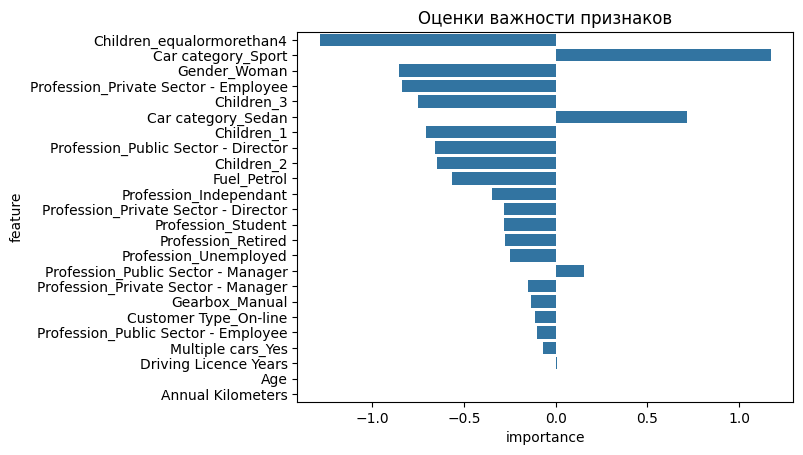

In [135]:
feature_scores = pd.DataFrame()
feature_scores['feature'] = cols
feature_scores['importance'] = model.coef_.flatten()
feature_scores['importance_abs'] = abs(model.coef_.flatten())
g = sns.barplot(feature_scores.sort_values('importance_abs', ascending=False), y = 'feature', x = "importance",)
plt.title('Оценки важности признаков')
plt.show()

По диаграмме видим, что гипотеза о том, что количество детей является наиболее важным признаком, в целом подтверждается. Если сказать точнее, то наличие четверых и более детей серьезно уменьшает вероятность страхового случая. Также мы видим, что если автомобиль спортивный, то это, наоборот серьезно увеличивает вероятность страхового случая. В целом важность этих и следющих признаков соответствует соображениям здравого смысла.

Теперь с помощью полученной модели определим вероятность страхового случая для 40-летнего мужчины, не имеющего детей, на машине типа SUV. Для этого сформируем матрицу объект-признак с одной строкой, соответствующей описанному случаю. Признаки, для которых в условии значения не заданы, заполним модой или медианой. После этого применим к получившейся матрице объект-признак методы OneHotEncoding и стандартизации, а затем применим к получившейся матрице модель логистической регрессии.

In [145]:
x = pd.DataFrame(
    {
        'Age': 40,
        'Gender': 'Man',
        'Children': '0',
        'Profession': X['Profession'].mode()[0],
        'Customer Type': X['Customer Type'].mode()[0],
        'Multiple cars': X['Multiple cars'].mode()[0],
        'Driving Licence Years': X['Driving Licence Years'].median(),
        'Car category': 'SUV',
        'Annual Kilometers':X['Annual Kilometers'].median(),
        'Gearbox':X['Gearbox'].mode()[0],  
        'Fuel':X['Fuel'].mode()[0],
    }, index=[0])


In [149]:
x_ohe = pd.concat(
    [
        x.drop(cat_columns, axis=1).reset_index(drop=True),
        pd.DataFrame(one_hot_encoder.transform(x[cat_columns]), columns = encoded_cat_columns).reset_index(drop=True)
    ],
    axis=1
)

x_ohe = scaler.transform(x_ohe)
model.predict_proba(x_ohe)[0,1]

0.5966345250170318

Таким образом, вероятность страхового случая для 40-летнего мужчины, не имеющего детей, на машине типа SUV составляет ~0.59.    

#### Задание 2
Определить наиболее значимые переменные, которые способствуют объяснению оттока клиентов.

##### Решение
Загрузим данные в DataFrame и посмотрим на них

In [8]:
df = pd.read_csv('Customer_Loyalty.csv', index_col='id')
df

,Gender,Salary,Marital,CheckingAccount,NumberOfSavingsAccounts,PersonalAccount,Mortgage,PensionPlan,Region,Status
id,,,,,,,,,,
13101,Female,38962.6,Single,No Checking Account,0,Personal Account,Mortgage,No Pension Plan 3,Land,0
13102,Male,39127.6,Single,No Checking Account,3,No Personal Account,Mortgage,Pension Plan 3,Land,1
13103,Male,77196.8,Married,No Checking Account,0,Personal Account,No Mortgage,Pension Plan 3,City,1
13104,Male,41508.6,Single,No Checking Account,0,No Personal Account,Mortgage,No Pension Plan 3,City,0
13105,Female,27729.2,Married,Checking Account,3,Personal Account 60 plus,No Mortgage,No Pension Plan 3,City,0
...,...,...,...,...,...,...,...,...,...,...
13096,Female,46971.8,Married,No Checking Account,3,Personal Account 60 plus,Mortgage,Pension Plan 3,Village,1
13097,Male,51537.2,Married,Checking Account,0,No Personal Account,No Mortgage,Pension Plan 3,Land,1
13098,Male,68364.4,Married,Checking Account,2,Personal Account,No Mortgage,No Pension Plan 3,City,0


Разобъем набор на матрицу объект-признак X и вектор целевой переменной y

In [9]:
y = df['Status']
X = df.drop('Status', axis=1)

Как и в предыдущем задании, закодируем категориальные признаки методом OneHotEncoding и нормализуем данные

In [12]:
cat_columns = X.select_dtypes(include=['object']).columns
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
one_hot_encoder = one_hot_encoder.fit(X[cat_columns])
encoded_cat_columns = one_hot_encoder.get_feature_names_out(cat_columns)
X_ohe = pd.concat(
    [
        X.drop(cat_columns, axis=1).reset_index(drop=True),
        pd.DataFrame(one_hot_encoder.transform(X[cat_columns]), columns=encoded_cat_columns).reset_index(drop=True)
    ],
    axis=1
)
cols = X_ohe.columns

In [13]:
scaler = StandardScaler()
scaler.fit(X_ohe)
X_ohe = scaler.transform(X_ohe)

Теперь обучим модель логистической регрессии и визуализируем значимость признаков

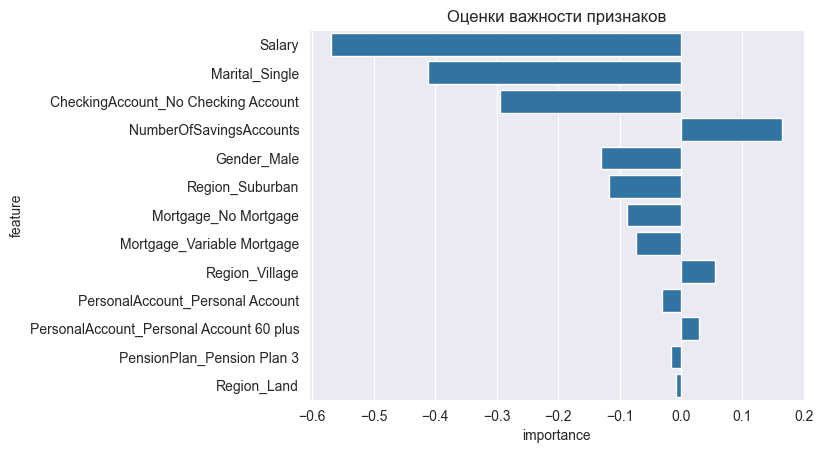

In [14]:
model = LogisticRegression(max_iter=5000, random_state=42)
model.fit(X_ohe, y)

feature_scores = pd.DataFrame()
feature_scores['feature'] = cols
feature_scores['importance'] = model.coef_.flatten()
feature_scores['importance_abs'] = abs(model.coef_.flatten())
sns.barplot(feature_scores.sort_values('importance_abs', ascending=False), y='feature', x="importance", )
plt.title('Оценки важности признаков')
plt.show()

По диаграмме видим, что наиболее значимым признаком, влияющим на лояльность клиента, является 'Salary'. Также важно семейное положение и наличие checking account
